Experiment with OpenCV for finding the pool table edges within an image

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def ImgShow(images, resolution=120):
    plt.rcParams['figure.dpi'] = resolution
    
    cnt = len(images)
    if cnt > 20:
        # Top-level object is an image, make it an array of 1
        images = [images]
        cnt = len(images)
        
    cols = cnt
    fig, ax = plt.subplots(1, cnt)    
    if 1 == cnt:
        ax = [ax]
    for i in range(0, len(images)):
        dims = len(images[i].shape)
        if 3 == dims:
            imgDisp = cv.cvtColor(images[i], cv.COLOR_BGR2RGB)
        else:
            imgDisp = cv.cvtColor(images[i], cv.COLOR_GRAY2RGB)
            
        ax[i].axis('off')
        ax[i].imshow(imgDisp)

In [3]:
# Load the test image
imageOriginal = cv.imread("../test/images/IMG_4430.jpg")

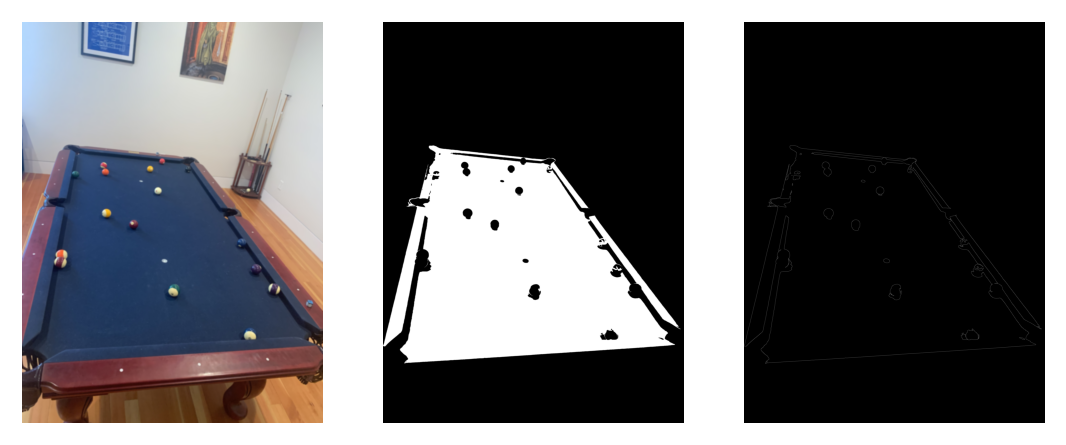

In [4]:
#Find the edges using flood, start with a blur
blur = int(25)
imageBlur = cv.GaussianBlur(imageOriginal, (blur,blur), cv.BORDER_DEFAULT)

imageFlood = imageBlur.copy()
cols = imageFlood.shape[1]
rows = imageFlood.shape[0]
seed = (int(cols / 2), int(rows / 2)) # a point in the middle

imageFloodMask = np.zeros((rows+2,cols+2,1), np.uint8)
tolerance = 32.0
diff = (tolerance,tolerance,tolerance)
#flags = 8 | cv.FLOODFILL_MASK_ONLY | 1 << 8
flags = 8 | cv.FLOODFILL_FIXED_RANGE | 255 << 8
res = cv.floodFill(imageFlood, imageFloodMask, seed, (0,0,255),diff,diff, flags)

# Edge detect using canny
imageCanny = cv.Canny(imageFloodMask, 100, 175)

ImgShow([imageBlur, imageFloodMask, imageCanny],220)

Find the line segments

In [ ]:
#Create default parametrization LSD
lsd = cv.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(imageCanny)[0] #Position 0 of the returned tuple are the detected lines
    
imageLstWithLines = lsd.drawSegments(imageCanny, lines)[..., -1]
ImgShow([imageFlood,imageLstWithLines])

In [ ]:
# HoughLinesP for detection
img = imageCanny

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 35  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 150  # minimum number of pixels making up a line
max_line_gap = 60  # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
tableEdgeLines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
print("tableEdgeLines count = " + str(len(tableEdgeLines)))

# For visualization, draw the lines onto a copy of the image
imageDrawnLines = np.copy(img) * 0  # creating a blank to draw lines on
for line in tableEdgeLines:
    for x1,y1,x2,y2 in line:
        cv.line(imageDrawnLines,(x1,y1),(x2,y2),(255,0,0),5)

# Draw the lines on the  image
imageDrawnEdges = cv.addWeighted(img, 0.8, imageDrawnLines, 1, 0)
ImgShow([img, imageDrawnEdges],300)
#print(tableEdgeLines)

# Find the outside lines
image_dx = imageFlood.shape[1]
image_dy = imageFlood.shape[0]

# Each item is an array of: maxval, line
lineT = [image_dy-1, [0,0,0,0]] # Start with a line on the bottom
lineB = [0, [0,0,0,0]]  # Start with a line on the top
lineL = [image_dx-1, [0,0,0,0]] # Start with a line on the right
lineR = [0, [0,0,0,0]]                 # Start with a line on the left

for line in tableEdgeLines:
    for x1,y1,x2,y2 in line:
        cv.line(imageDrawnLines,(x1,y1),(x2,y2),(255,0,0),5)

In [ ]:
# Find edge of cloth by angle groupings
class LineP:
    def __init__(self, x1,y1, x2,y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        rise = y2 - y1
        run = x2 - x1
        self.m = rise/run
        self.b = y1 - self.m * x1
        
    def angleRad(self):
        return np.arctan(self.m)
    
    def angleDeg(self):
        return self.angleRad() * 180.0 / math.pi
    
    def length(self):
        rise = self.y2 - self.y1
        run = self.x2 - self.x1
        return math.sqrt(rise * rise + run * run)

# Create an array of line objects. Also, we want to finde the 'pseudo-center' of the
# lines. We will do this using the endpoints.
xsum = 0
ysum = 0
lineObjs = []
for line in tableEdgeLines:
    for x1,y1,x2,y2 in line:
        lineObjs.append(LineP(x1,y1,x2,y2))
        xsum += x1
        xsum += x2
        ysum += y1
        ysum += y2

# 'pseudo-center'
center_x = xsum / len(tableEdgeLines) / 2
center_y = ysum / len(tableEdgeLines) / 2

lineObjs.sort(key=lambda s: s.angleDeg()) # sorts using lambda function
#print("After Sort")
#for p in lineObjs:
#    print(p.angleDeg())
        

In [ ]:
# Contours
img = imageOriginal.copy()
imgGray = imageFloodMask.copy()
#imgray = cv.cvtColor(imageFloodMask, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgGray, 127, 255, 0)
contours, b, = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img, contours, -1, (0,255,0),3)
ImgShow([thresh,img])

In [ ]:
# Alternate method using Harris Corner Detection
img = imageFloodMask.copy()

blockSize = 2
ksize = 3
k = 0.04
corners = cv.cornerHarris(img, blockSize, ksize, k)

#result is dilated for marking the corners, not important
corners = cv.dilate(corners, None)

# Threshold for an optimal value, it may vary depending on the image.
imgDrawnCorners = imageOriginal.copy()
#imgDrawnCorners[corners>0.01*corners.max()]=[0,0,255]
ImgShow([imgDrawnCorners, corners])

In [ ]:
img = imageOriginal.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

blockSize = 20
ksize = 21
k = 0.04
imgCorners = cv.cornerHarris(gray,blockSize,ksize,k)
#result is dilated for marking the corners, not important
#dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[imgCorners>0.01*imgCorners.max()]=[0,0,255] # << Brendan, how is this working? There is some implied loop
ImgShow([img, imgCorners],200)

In [ ]:
# Shi-Tomasi corner detection
img = imageOriginal.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

maxCorners = 20
qualityLevel = 0.01
minDistance = 30
blockSize = 20
corners = cv.goodFeaturesToTrack(gray, maxCorners, qualityLevel, minDistance, cv.noArray, blockSize)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),7,(0,0,255),-1)
    
ImgShow(img, 250)

In [ ]:
import urllib
import cv2 as cv

url = "https://www.cameraftp.com/cameraftp/publish/Camera.aspx/parentID197686853/shareID13469020/Sunset"
rstp = "rtsp://wowzaec2demo.streamlock.net/vod/mp4:BigBuckBunny_115k.mp4"
cap = cv.VideoCapture(rstp)
while True:
    ret,frame=cap.read()
    cv.imshow("RTSP",frame)
    k = cv.waitKey(1)
    if( k == ord('q')):
        break
    
#resp = urllib.urlopen(url)
#img = np.array(bytearray(resp.read))